In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load dataset
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0232EN-SkillsNetwork/asset/airlines_data.xlsx'
data = pd.read_excel(url)

data.head()


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:

print("Shape of dataset:", data.shape)
print("\nColumns and types:\n", data.dtypes)
print("\nSummary statistics for numeric columns:\n", data.describe())
print("\nMissing values:\n", data.isnull().sum())


Shape of dataset: (10683, 11)

Columns and types:
 Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

Summary statistics for numeric columns:
               Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000

Missing values:
 Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [5]:
#plan
exploration_plan = """
1. Analyze ticket prices (Price) by airline, source, destination.
2. View ticket price distribution: histogram, boxplot.
3. Check the time of variables: day, flight time.
4. Divide the number of stops (Total_Stops) affecting ticket prices.
5. Check for missing data and process data.
6. Feature engineering: create columns Day, Month, Arrival Time, Duration_minute.
7. Relationship between variables and Price: correlation.
"""
print(exploration_plan)



1. Analyze ticket prices (Price) by airline, source, destination.
2. View ticket price distribution: histogram, boxplot.
3. Check the time of variables: day, flight time.
4. Divide the number of stops (Total_Stops) affecting ticket prices.
5. Check for missing data and process data.
6. Feature engineering: create columns Day, Month, Arrival Time, Duration_minute.
7. Relationship between variables and Price: correlation.



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns




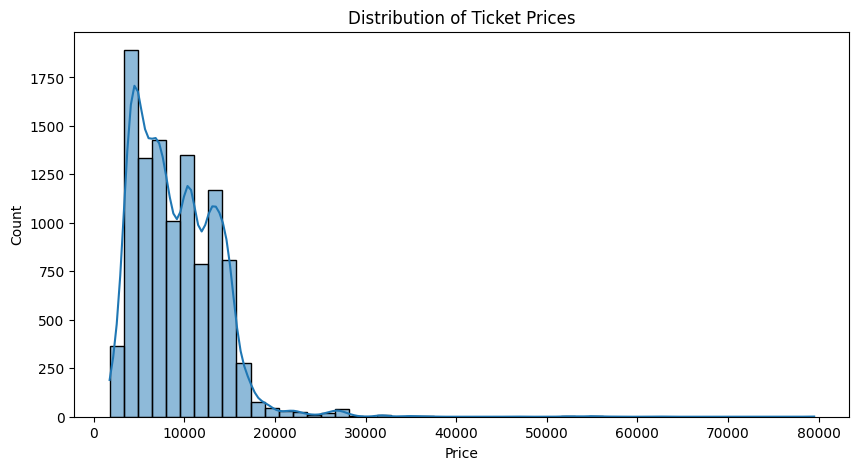

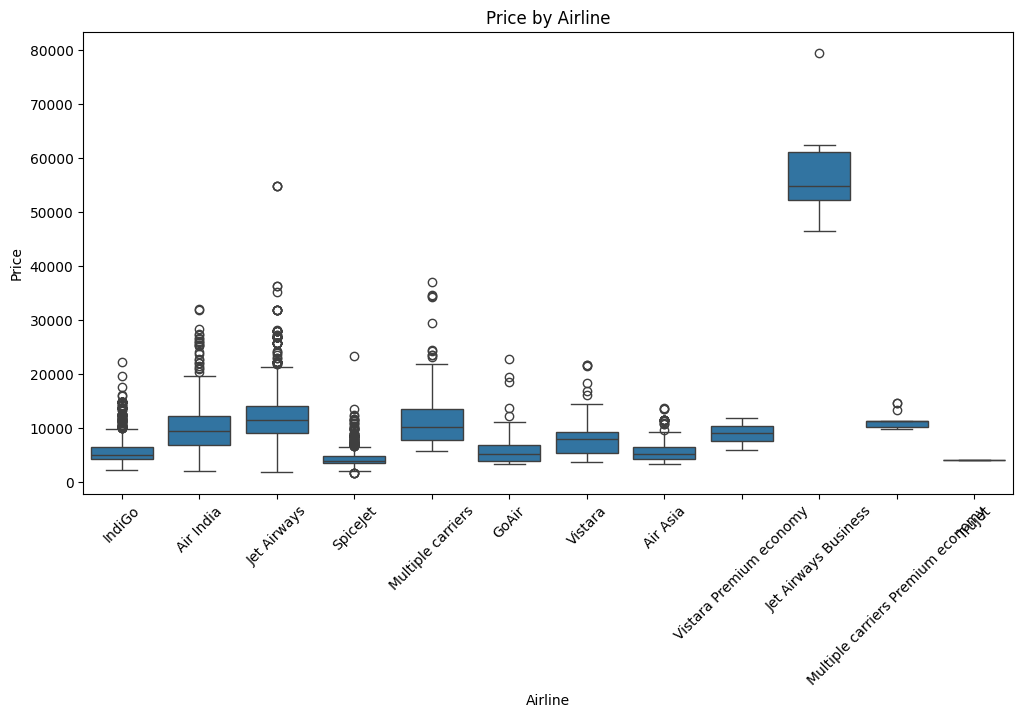

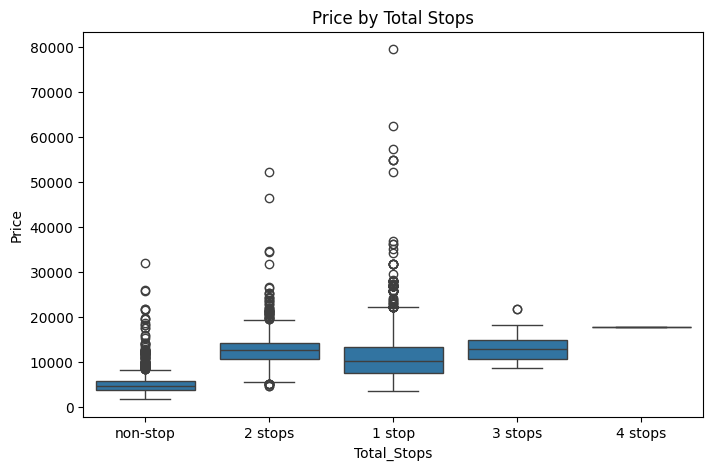

In [7]:
# phân phối giá vé
plt.figure(figsize=(10,5))
sns.histplot(data['Price'], bins=50, kde=True)
plt.title("Distribution of Ticket Prices")
plt.show()

# giá vé theo hãng
plt.figure(figsize=(12,6))
sns.boxplot(x='Airline', y='Price', data=data)
plt.xticks(rotation=45)
plt.title("Price by Airline")
plt.show()

# giá vé điểm dừng
plt.figure(figsize=(8,5))
sns.boxplot(x='Total_Stops', y='Price', data=data)
plt.title("Price by Total Stops")
plt.show()

In [ ]:

data['Airline'] = np.where(data['Airline']=='Multiple carriers Premium economy', 
                           'Multiple carriers', data['Airline'])

data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format="%d/%m/%Y")
data['Day'] = data['Date_of_Journey'].dt.day
data['Month'] = data['Date_of_Journey'].dt.month
data['Year'] = data['Date_of_Journey'].dt.year


data['Arrival_Hour'] = pd.to_datetime(data['Arrival_Time']).dt.hour

data['arr_timezone'] = pd.cut(data['Arrival_Hour'], 
                              bins=[0,6,12,18,24], 
                              labels=['Night','Morning','Afternoon','Evening'])

def duration_to_min(duration):
    h, m = 0,0
    if 'h' in duration:
        h = int(duration.split('h')[0])
    if 'm' in duration:
        m = int(duration.split('h')[-1].replace('m',''))
    return h*60 + m

data['Duration_min'] = data['Duration'].apply(duration_to_min)


data.isnull().sum()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2552\2161275085.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Arrival_Hour'] = pd.to_datetime(data['Arrival_Time']).dt.hour


Airline              0
Date_of_Journey      0
Source               0
Destination          0
Route                0
Dep_Time             0
Arrival_Time         0
Duration             0
Total_Stops          0
Additional_Info      0
Price                0
Day                  0
Month                0
Year                 0
Arrival_Hour         0
arr_timezone       322
Duration_min         0
dtype: int64

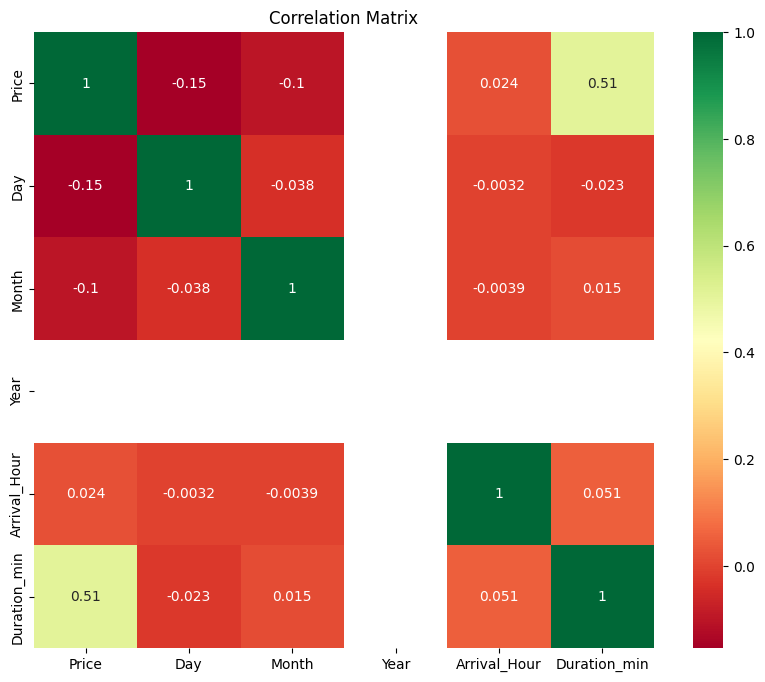


1. Ticket prices increase with Duration_min (longer flight time, higher price)
2. Ticket prices vary between airlines
3. Ticket prices are usually higher when there are fewer stops
4. Flight time (Morning/Afternoon/Evening) has little effect on price



In [13]:

plt.figure(figsize=(10,8))
sns.heatmap(data[['Price','Day','Month','Year','Arrival_Hour','Duration_min']].corr(), annot=True, cmap='RdYlGn')
plt.title("Correlation Matrix")
plt.show()

insights = """
1. Ticket prices increase with Duration_min (longer flight time, higher price)
2. Ticket prices vary between airlines
3. Ticket prices are usually higher when there are fewer stops
4. Flight time (Morning/Afternoon/Evening) has little effect on price
"""
print(insights)


In [15]:

hypotheses = """
H1: Flights with fewer stops are more expensive.
H2: Jet Airways fares are higher than other airlines.
H3: Morning flights are more expensive than Evening flights.
"""
print(hypotheses)



H1: Flights with fewer stops are more expensive.
H2: Jet Airways fares are higher than other airlines.
H3: Morning flights are more expensive than Evening flights.



In [16]:
from scipy.stats import ttest_ind

# H1: 0 stops vs 1 stop
price_0stop = data[data['Total_Stops']=='non-stop']['Price']
price_1stop = data[data['Total_Stops']=='1 stop']['Price']

t_stat, p_value = ttest_ind(price_0stop, price_1stop)
alpha = 0.05

print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < alpha:
    print("Reject null hypothesis: 0 stops price is different from 1 stop")
else:
    print("Fail to reject null hypothesis")


t-statistic: -71.78181267095813
p-value: 0.0
Reject null hypothesis: 0 stops price is different from 1 stop


In [18]:
conclusion = """
- Duration and number of stops are important factors affecting ticket prices.
- Airlines also significantly affect prices.
- It is possible to develop a ticket price prediction model based on Duration, Stops, Airline, Arrival_Hour,...
Next steps:
1. Process categorical variables using one-hot encoding
2. Normalize numeric data
3. Train Regression model (Linear/RandomForest)
4. Evaluate model using RMSE/MAE
Kha ok
"""
print(conclusion)



- Duration and number of stops are important factors affecting ticket prices.
- Airlines also significantly affect prices.
- It is possible to develop a ticket price prediction model based on Duration, Stops, Airline, Arrival_Hour,...
Next steps:
1. Process categorical variables using one-hot encoding
2. Normalize numeric data
3. Train Regression model (Linear/RandomForest)
4. Evaluate model using RMSE/MAE
Kha ok

